# KNIT6
# MF_Timestamp_Service(standalone setup, no measurement node)

## Timestamp Service Overview(You can pull/run the containers on any node in your slice)

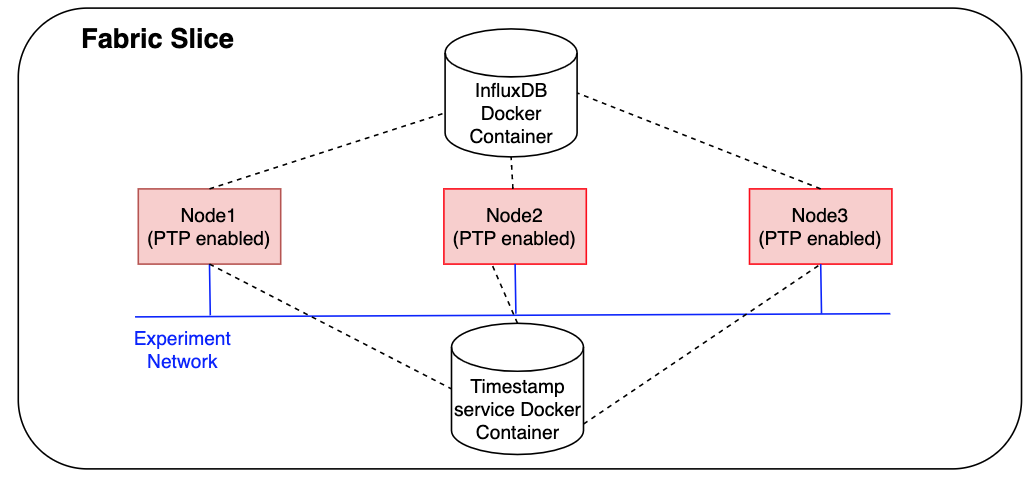

## Prerequisites

##### The node to run the timestamp service must have **docker**, **linuxptp** installed and configured.
##### For nodes on IPv6 sites, follow the instructions in this [fabric knowledge base article](https://learn.fabric-testbed.net/knowledge-base/using-ipv4-only-resources-like-github-or-docker-hub-from-ipv6-fabric-sites/) to access IPv4 resources(github and dockerhub).
##### Make sure there is no docker containers named timestamp or influxdb running on the nodes 

## Imports
This series of notebooks all need a common set of imports which are defined in [Common Imports](./KNIT6_common_imports.ipynb)

**slice_name** is defined in this step. If you would like to change the slice_name, edit [Common Imports](./KNIT6_common_imports.ipynb)

In [ ]:
%run "./KNIT6_common_imports.ipynb"

In [ ]:
from mflib.mf_timestamp import mf_timestamp 

## Slice info

In [ ]:
# Change your slice name and node name(This is an example of a 3 node topology)
# set in KNIT6_common_imports.ipynb slice_name="MyMonitoredSlice"
container_name="timestamp"
node1_name = 'Node1'
node2_name = 'Node2'
node3_name = 'Node3'

## Find all Experiment Nodes

In [ ]:
try:
    slice = fablib.get_slice(name=slice_name)
except Exception as e:
    print(f"Fail: {e}")

print (slice)    

try:
    node1 = slice.get_node(name=node1_name)
    node2 = slice.get_node(name=node2_name)
    node3 = slice.get_node(name=node3_name)
except Exception as e:
    print(f"Fail: {e}")
#print (node1)
#print (node2)
#print (node3)

## Check whether Nodes are on PTP-capable sites

In [ ]:
ptp_capable_sites=['STAR','MAX','MICH','MASS','UTAH','NCSA','UCSD','FIU','CLEM','CERN','INDI']
nodes_on_ptp_sites=[]
for node in slice.get_nodes():
    site=node.get_site()
    name=node.get_name()
    if (site in ptp_capable_sites):
        print (f"{name} on {site} is ptp capable")
        nodes_on_ptp_sites.append(node)
    else:
        print (f"{name} on {site} is not ptp capable")

## Ensure PTP is running

In [ ]:
for node in nodes_on_ptp_sites:
    site=node.get_site()
    name=node.get_name()
    if (site in ptp_capable_sites):
        print (f"{name}")
        node.execute("ps -ef | grep phc2sys")

## Set host names of the nodes

In [ ]:
cmd = f"sudo hostnamectl set-hostname `cat /var/lib/cloud/data/previous-hostname`"
for node in [node1, node2, node3]:
    node.execute(cmd)

## Setup timestamp service on nodes

### Pull and run the timestamp docker image as a container on the experiment node

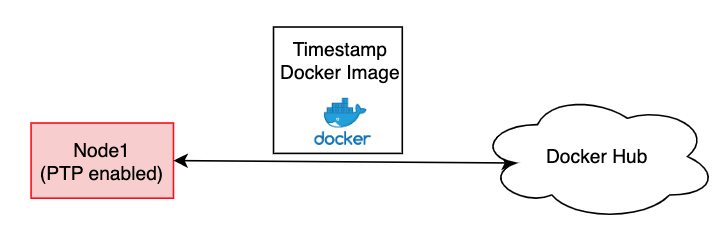

In [ ]:
# Specify the bind mount volume
timestamp_bind_mount_volume = "/home/rocky/timestamp/"
cmd = f'''
      sudo docker run -dit \
      -v {timestamp_bind_mount_volume}:/root/services/timestamp/output_files/ \
      --pid=host --network=host --privileged \
      --name timestamp fabrictestbed/timestamp:0.1.1
      '''
node1.execute(cmd)
#node2.execute(cmd)
#node3.execute(cmd)

### Check on Node1 if timestamp docker container is running

In [ ]:
command = f"sudo docker ps"
stdout, stderr= node1.execute(command)

## Create the object

In [ ]:
ts = mf_timestamp(slice_name=slice_name, container_name=container_name)

## Specify the name of the timestamp experiment

In [ ]:
packet_test_name="packet-test"
event_test_name="event-test"

<font color=blue size="6">*Timestamping Packets*</font>
### This method will first trigger tcpdump to record packets and then process the results

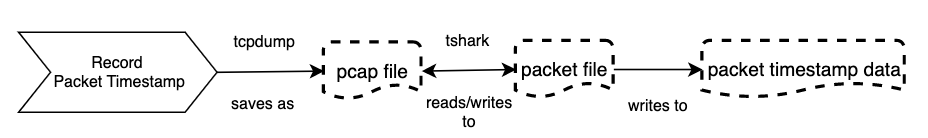

In [ ]:
# To see which interface to use
slice.list_interfaces()

### Prepare to run iperf tests

#### SSH into Node1 and Node2

In [ ]:
#List the management IPs of Node1 and Node2
try:
    node1_management_ip=node1.get_management_ip()
    node2_management_ip= node2.get_management_ip()
except Exception as e:
    print(f"Fail: {e}")
user="rocky"
fabric_ssh_config_path= "ssh_config"
slice_key_path = "slice_key"
print (f"Go to the dir where you untar 'fabric_ssh_tunnel_tools.gz' and run the cmd to ssh into Node1")
print (f"ssh -F {fabric_ssh_config_path} -i {slice_key_path} {user}@{node1_management_ip}")
print (f"Go to the dir where you untar 'fabric_ssh_tunnel_tools.gz' and run the cmd to ssh into Node2")
print (f"ssh -F {fabric_ssh_config_path} -i {slice_key_path} {user}@{node2_management_ip}")

#### Run iperf3 tests

In [ ]:
# find the ip address of an interface
# Specify the name of the experiment you set up on Node1
node1_network_name="net1"
for iface in node1.get_interfaces():
    if (node1_network_name in iface.get_network().get_name()):
        node1_experiment_net_IP = iface.get_ip_addr()
        node1_physical_interface= iface.get_physical_os_interface_name()
iperf_server_cmd="sudo iperf3 -s"
iperf_client_cmd=f"sudo iperf3 -c {node1_experiment_net_IP} -t 10"
print (f"Go to your Node1 SSH terminal and run: {iperf_server_cmd}")
print (f"Go to your Node2 SSH terminal and run: {iperf_client_cmd}")
print (f"The interface name on Node1 is: {node1_physical_interface} (to be used in the cell below)")

In [ ]:
# Need to Check the interface name ens/eth on that node and pass as a parameter
# Prepare to run iperf from node2 to this experiment node in the terminal 
# e.g, On node1: sudo iperf3 -s    On Node2: sudo iperf -c {node1_IP_address} -t 10
ts.record_packet_timestamp(node=node1_name,name=packet_test_name, interface="ens7",ipversion="4",
                           protocol="tcp", duration="10", verbose=True)

### Get the recorded packet timestamp from local file

In [ ]:
# May run into IOPub data rate exceeded error if you have large data
packet_records= ts.get_packet_timestamp(node=node1_name, name=packet_test_name)

### Download the packet timestamp data file from Node1

In [ ]:
file_download_path = "/home/fabric/work/packet_timestamp.json" 
ts.download_timestamp_file(node=node1_name, data_type="packet_timestamp",
                           local_file=file_download_path,
                           bind_mount_volume=timestamp_bind_mount_volume)

### Inspect the data format from the downloaded file

In [ ]:
# A list of json objects
with open(file_download_path, 'r') as f:
    result = json.load(f)
print (result[0])

### Local Data Visualization using matplotlib 

In [ ]:
ts.plot_packet_timestamp(json_obj=result)

<font color=blue size="6">*Timestamping Events*</font>

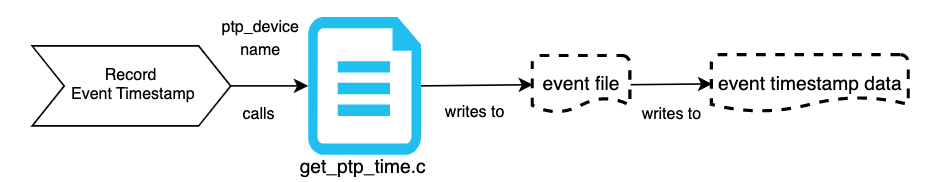

In [ ]:
ts.record_event_timestamp(node=node1_name,name=event_test_name,event="'ram usage above 80 percent'", verbose=True)

### Get the recorded event timestamp

In [ ]:
event_records=ts.get_event_timestamp(node=node1_name,name=event_test_name)

<font color=blue size="6">*Interacting With the Database*</font>

## Setup influxdb service on Node2 to store timestamp data

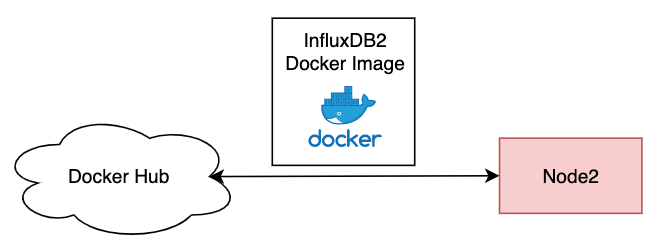

### Pull the influxdb image and run the docker container on Node2

In [ ]:
# Specify the influxdb bind mount volume
influxdb_bind_mount_volume="/home/rocky/influxdb"
cmd = f'''
      sudo docker run --privileged -d \
      -v {influxdb_bind_mount_volume}:/var/lib/influxdb2 \
      -e DOCKER_INFLUXDB_INIT_MODE=setup \
      -e DOCKER_INFLUXDB_INIT_USERNAME=my-user \
      -e DOCKER_INFLUXDB_INIT_PASSWORD=my-password \
      -e DOCKER_INFLUXDB_INIT_ORG=my-org \
      -e DOCKER_INFLUXDB_INIT_BUCKET=my-bucket \
      --network=host --privileged \
      --name influxdb influxdb:2.0
      '''
node2.execute(cmd)

### Check influxdb docker container on Node2 

In [ ]:
command = f"sudo docker ps"
stdout, stderr= node2.execute(command)

## Get influxdb info from Node2

### List influxdb info

In [ ]:
print ("List buckets")
command = f"sudo docker exec influxdb influx bucket list -o my-org"
stdout, stderr= node2.execute(command)

print ("\nList orgs")
command = f"sudo docker exec influxdb influx org list --json"
stdout, stderr= node2.execute(command)
try:
    org_id = str(json.loads(stdout)[0]["id"])
except Exception as e:
    print(f"Fail: {e}")

print ("\nList tokens")
command = f"sudo docker exec influxdb influx auth list --json"
stdout, stderr= node2.execute(command)

## Upload data to influxdb

### Load influx info

In [ ]:
try:
    token = str(json.loads(stdout)[0]["token"])
except Exception as e:
    print(f"Fail: {e}")
bucket = "my-bucket"
org="my-org"  
print (f"InfluxDB info: org: {org}, bucket: {bucket}, token: {token}")

### Upload packet and event data to influxdb

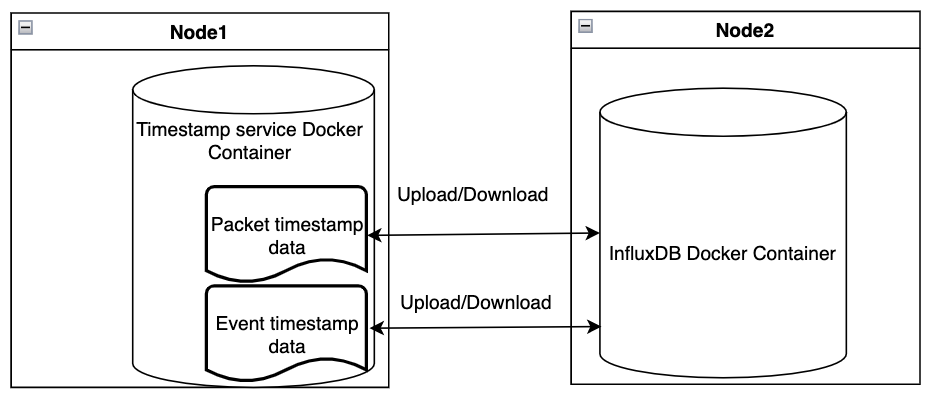

### Find the influxdb node IP

In [ ]:
# Specify which node influxdb is running on
influxdb_node_name=node2
# Specify the experiment network name you added on node2
node2_iface = node2.get_interface(network_name="net2") 
influxdb_ip=node2_iface.get_ip_addr()
print (influxdb_ip)

### Upload timestamp data

In [ ]:
ts.upload_timestamp_to_influxdb(node=node1_name, data_type="packet_data", 
                                bucket=bucket, org=org, token=token, influxdb_ip=influxdb_ip)

In [ ]:
ts.upload_timestamp_to_influxdb(node=node1_name, data_type="event_data", 
                                bucket=bucket, org=org, token=token, influxdb_ip=influxdb_ip)

## If you want to see the json output

### Print packet data from influxdb

In [ ]:
# May run into IOPub data rate exceeded error if you have large data
ts.download_timestamp_from_influxdb(node=node1_name, data_type="packet_data", 
                                    bucket=bucket, org=org, token=token, 
                                    name=packet_test_name, influxdb_ip=influxdb_ip)

### Generate a .csv data file based on query on the Influxdb node

In [ ]:
ts.generate_csv_on_influxdb_node(data_node=node1_name, name=packet_test_name, data_type="packet_timestamp", 
                                    bucket=bucket, org=org, token=token,influxdb_node_name=node2_name)

### Download the .csv file from influxdb

In [ ]:
# Specify jupyterhub path for the downloaed file
local_file=f"/home/fabric/work/influxdb_{node1_name}_packet_timestamp.csv"
ts.download_file_from_influxdb(data_node=node1_name, data_type="packet_timestamp", 
                               influxdb_node_name=node2_name,local_file=local_file)

### Inspect the data format from the .csv file

In [ ]:
import pandas as pd
df = pd.read_csv(local_file)
print(df.iloc[0])

### Print event timestamp data

In [ ]:
ts.download_timestamp_from_influxdb(node=node1_name, data_type="event_data", 
                                    bucket=bucket, org=org, token=token, 
                                    name=event_test_name, influxdb_ip=influxdb_ip)

## Visualize the influxdb web UI

In [ ]:
# Set up ssh tunneling to meas node
# ssh -L 10030:localhost:8086 -F ~/.ssh/fabric_ssh_config -i ~/.ssh/fabric_slice_key rocky@node2_management_ip 
local_port="10030"
influxdb_port="8086"
user = "rocky"
fabric_ssh_config_path= "ssh_config"
slice_key_path = "slice_key"
try:
    node2_management_ip=node2.get_management_ip()
except Exception as e:
    print(f"Fail: {e}")
print (f"SSH command to tunnel to node2 for influxdb:")
print (f"Go to the dir where you untar 'fabric_ssh_tunnel_tools.gz' and run the cmd to ssh into Node2")
print (f"ssh -L {local_port}:localhost:{influxdb_port} -F {fabric_ssh_config_path} -i {slice_key_path} {user}@{node2_management_ip}")
URL=f"http://localhost:{local_port}/orgs/{org_id}/data-explorer?bucket={bucket}"
print (f"Browse to {URL} to access InfluxDB web UI")

In [ ]:
# Username: my-user password: my-password
# If you are using Google Chrome to run this cell, you might encounter login loop
from IPython.display import IFrame
IFrame(URL, width=1200, height=1000)

### Upload Custom Dashboard

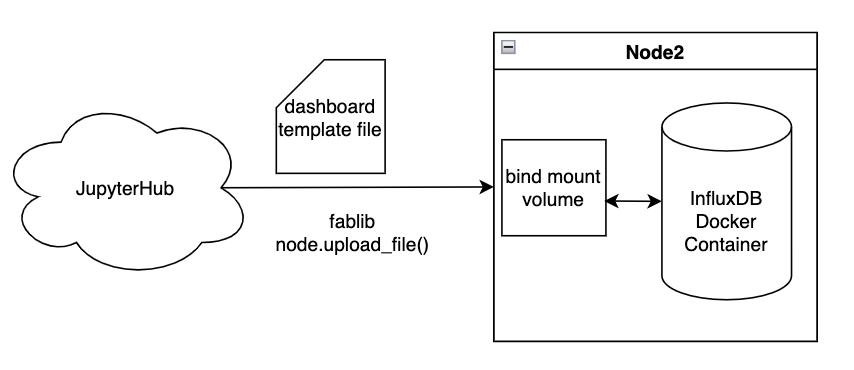

In [ ]:
# Use mf_timestamp to deploy dashboard template file
cwd = os.getcwd()
dashboard_file_relative_path = "dashboard_examples/influxdb/influxdb_timestamp_dashboard.yml"
dashboard_file_real_path = os.path.join(cwd, dashboard_file_relative_path)
ts.deploy_influxdb_dashboard(dashboard_file=dashboard_file_real_path,influxdb_node_name= node2_name, 
                             bind_mount_volume=influxdb_bind_mount_volume)

# Or
# Upload the dashboard file to the directory on meas_node that binds mount on influxdb container
#node2.upload_file(local_file_path=dashboard_file_real_path, remote_file_path="/home/rocky/influxdb/dashboard.yml")

# Apply the template in influxdb 
#command = f"sudo docker exec -i influxdb influx apply --skip-verify --file /var/lib/influxdb2/dashboard.yml"
#stdout, stderr= node2.execute(command)

## Stop the services 

In [ ]:
# Find the timestamp container id and stop the container
stdout=node1.execute("sudo docker ps -aqf 'name=timestamp'", quiet=True)
timestamp_container_id=stdout[0]
stdout,stderr= node1.execute(f"sudo docker container stop {timestamp_container_id}", quiet=True)

In [ ]:
# Find the influxdb container id and stop the container
stdout=node2.execute("sudo docker ps -aqf 'name=influxdb'", quiet=True)
influxdb_container_id=stdout[0]
stdout,stderr= node2.execute(f"sudo docker container stop {influxdb_container_id}", quiet=True)

## Remove the services

In [ ]:
# Remove the container
stdout,stderr= node1.execute(f"sudo docker rm -v timestamp", quiet=True)
# Remove the timestamp docker image
stdout,stderr= node1.execute("sudo docker rmi -f fabrictestbed/timestamp:0.1.1")
# Remove the bind mount volume
stdout,stderr= node1.execute(f"sudo rm -rf {timestamp_bind_mount_volume}")

In [ ]:
# Remove the container
stdout,stderr= node2.execute(f"sudo docker rm -v influxdb", quiet=True)
# Remove the influxdb docker image
stdout,stderr= node2.execute("sudo docker rmi -f influxdb:2.0")
# Remove the bind mount volume
stdout,stderr= node2.execute(f"sudo rm -rf {influxdb_bind_mount_volume}")

In [ ]:
stdout,stderr= node1.execute("sudo docker ps -a")
stdout,stderr= node1.execute("sudo docker image ls")

In [ ]:
stdout,stderr= node2.execute("sudo docker ps -a")
stdout,stderr= node2.execute("sudo docker image ls")